# Neural Machine Translation: English → Urdu
## DS-462 Gen AI with LLM 

**Student ID:** 2022220  
**Date:** 19 October 2025

---

## Assignment Overview

This notebook implements and compares **four machine translation models**:
1. **RNN Encoder-Decoder**
2. **LSTM Encoder-Decoder**
3. **GRU Encoder-Decoder**
4. **Transformer (Attention-based)**

### Dataset
- **Source:** English-Urdu Parallel Corpus
- **Size:** 50,000 sentence pairs
- **Task:** English → Urdu Translation

### Evaluation Metrics
✓ BLEU Score  
✓ CHRF Score  
✓ Perplexity  
✓ METEOR  
✓ BERTScore

---


In [ ]:
# !pip install nltk bert-score sacrebleu -q

import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import re
import os
import json
import time
import pickle
from pathlib import Path

# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GRU, Dropout
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Attention, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Evaluation metrics
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

# Checking GPU availability
print('TensorFlow version:', tf.__version__)
print('GPU Available:', tf.config.list_physical_devices('GPU'))
print('\n✓ All libraries imported successfully')

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✓ All libraries imported successfully


### Global Configuration

In [ ]:
# Global Configuration for all models
class Config:
    # Data parameters
    NUM_SAMPLES = 50000        # Use 50,000 sentence pairs
    MAX_VOCAB_SIZE = 15000     # Vocabulary size (Colab-friendly---originally it was about 50,000)
    MAX_LENGTH = 40            # Maximum sentence length

    # Model parameters
    EMBEDDING_DIM = 128        # Embedding dimension
    HIDDEN_UNITS = 128         # RNN/LSTM/GRU hidden units

    # Training parameters
    BATCH_SIZE = 64            # Batch size
    EPOCHS = 15                # Training epochs
    VALIDATION_SPLIT = 0.1     # Validation split
    TEST_SPLIT = 0.1           # Test split

    # Paths
    DATA_DIR = Path('.')
    RESULTS_DIR = Path('results')
    MODELS_DIR = Path('models')

    def __init__(self):
        # Create directories
        self.RESULTS_DIR.mkdir(exist_ok=True)
        self.MODELS_DIR.mkdir(exist_ok=True)

config = Config()

print('Configuration:')
print(f'  Samples: {config.NUM_SAMPLES:,}')
print(f'  Vocabulary Size: {config.MAX_VOCAB_SIZE:,}')
print(f'  Max Length: {config.MAX_LENGTH}')
print(f'  Embedding Dim: {config.EMBEDDING_DIM}')
print(f'  Hidden Units: {config.HIDDEN_UNITS}')
print(f'  Batch Size: {config.BATCH_SIZE}')
print(f'  Epochs: {config.EPOCHS}')

Configuration:
  Samples: 50,000
  Vocabulary Size: 15,000
  Max Length: 40
  Embedding Dim: 128
  Hidden Units: 128
  Batch Size: 64
  Epochs: 15


---

## 1. Dataset Selection & Justification

**Dataset Name:** English-Urdu Parallel Corpus  
**Dataset Source:**  
[Urdu–English Machine Translation Dataset (GitHub)](https://github.com/Kheem-Dh/Urdu-to-English-Machine-Translation-using-Seq2Seq-Transformers-Variant-Model)
**Languages:** English (source) → Urdu (target)  
**Total Sentence Pairs:** 50,000 (selected from 100,000)  

### Why This Dataset is Challenging

1. **Script Difference:** English uses Latin script while Urdu uses Arabic script (right-to-left)
2. **Grammar Structure:** Urdu follows Subject-Object-Verb (SOV) order vs English Subject-Verb-Object (SVO)
3. **Morphological Complexity:** Urdu has rich inflections and compound words
4. **Context-Dependent Translation:** Same words translate differently based on context
5. **Low-Resource Language:** Limited parallel data compared to high-resource language pairs
6. **Informal Expressions:** Dataset contains colloquial language and idiomatic expressions

## 2. Data Preprocessing

### Step 1: Load and Clean Data

In [3]:
def clean_text(text):
    """Clean text: lowercase, remove punctuation/numbers, strip whitespace"""
    text = text.lower()
    # Keep Urdu unicode range and English letters
    text = re.sub(r'[^\u0600-\u06FFa-z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Load data
print('Loading English-Urdu parallel corpus...')
with open('English.txt', 'r', encoding='utf-8-sig', errors='ignore') as f:
    english_sentences = f.read().strip().split('\n')

with open('Urdu.txt', 'r', encoding='utf-8-sig', errors='ignore') as f:
    urdu_sentences = f.read().strip().split('\n')

print(f'Total sentences loaded: {len(english_sentences):,}')

# Clean and filter data
eng_clean = []
urdu_clean = []

for eng, urdu in zip(english_sentences, urdu_sentences):
    eng_c = clean_text(eng)
    urdu_c = clean_text(urdu)

    # Filter: non-empty, reasonable length
    if (eng_c and urdu_c and
        len(eng_c.split()) <= config.MAX_LENGTH and
        len(urdu_c.split()) <= config.MAX_LENGTH and
        len(eng_c.split()) >= 2 and
        len(urdu_c.split()) >= 2):
        eng_clean.append(eng_c)
        urdu_clean.append(urdu_c)

    # Stop at desired number
    if len(eng_clean) >= config.NUM_SAMPLES:
        break

print(f'Cleaned sentences: {len(eng_clean):,}')

# Compute statistics
avg_eng_len = np.mean([len(s.split()) for s in eng_clean])
avg_urdu_len = np.mean([len(s.split()) for s in urdu_clean])

print(f'\nDataset Statistics:')
print(f'  Average English length: {avg_eng_len:.2f} words')
print(f'  Average Urdu length: {avg_urdu_len:.2f} words')

# Display samples
print(f'\nSample Data:')
for i in range(3):
    print(f'{i+1}. EN: {eng_clean[i]}')
    print(f'   UR: {urdu_clean[i]}')
    print()

Loading English-Urdu parallel corpus...
Total sentences loaded: 100,000
Cleaned sentences: 50,000

Dataset Statistics:
  Average English length: 12.41 words
  Average Urdu length: 15.83 words

Sample Data:
1. EN: los angeles has lost night straight and  of its first  games to start the season
   UR: لاس اینجلس نے سیزن شروع کرنے کے لئے سیدھے رات اور اپنے پہلے  میں سے  کھیل کھوئے ہیں۔

2. EN: opposite qualities of meaning of persons name
   UR: آنکھ کا اندھا نام نین سکھ

3. EN: to show anger after getting embarrassed
   UR: کھسیانی بلی کھمبا نوچے



### Step 2: Prepare Sequences with Start/End Tokens

In [4]:
# Prepare decoder sequences with special tokens
decoder_input_data = ['<start> ' + s for s in urdu_clean]
decoder_target_data = [s + ' <end>' for s in urdu_clean]

print('Decoder sequence examples:')
print(f'Input:  {decoder_input_data[0]}')
print(f'Target: {decoder_target_data[0]}')

Decoder sequence examples:
Input:  <start> لاس اینجلس نے سیزن شروع کرنے کے لئے سیدھے رات اور اپنے پہلے  میں سے  کھیل کھوئے ہیں۔
Target: لاس اینجلس نے سیزن شروع کرنے کے لئے سیدھے رات اور اپنے پہلے  میں سے  کھیل کھوئے ہیں۔ <end>


### Step 3: Tokenization and Vocabulary Building

In [5]:
# Tokenize English (source)
eng_tokenizer = Tokenizer(num_words=config.MAX_VOCAB_SIZE, oov_token='<OOV>')
eng_tokenizer.fit_on_texts(eng_clean)
eng_sequences = eng_tokenizer.texts_to_sequences(eng_clean)

eng_vocab_size = min(len(eng_tokenizer.word_index) + 1, config.MAX_VOCAB_SIZE)
print(f'English vocabulary size: {eng_vocab_size:,}')

# Tokenize Urdu (target)
urdu_tokenizer = Tokenizer(num_words=config.MAX_VOCAB_SIZE, filters='', oov_token='<OOV>')
urdu_tokenizer.fit_on_texts(decoder_input_data + decoder_target_data)

decoder_input_sequences = urdu_tokenizer.texts_to_sequences(decoder_input_data)
decoder_target_sequences = urdu_tokenizer.texts_to_sequences(decoder_target_data)

urdu_vocab_size = min(len(urdu_tokenizer.word_index) + 1, config.MAX_VOCAB_SIZE)
print(f'Urdu vocabulary size: {urdu_vocab_size:,}')

# Save tokenizers
with open(config.MODELS_DIR / 'eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(eng_tokenizer, f)
with open(config.MODELS_DIR / 'urdu_tokenizer.pkl', 'wb') as f:
    pickle.dump(urdu_tokenizer, f)

print('\n✓ Tokenizers saved')

English vocabulary size: 15,000
Urdu vocabulary size: 15,000

✓ Tokenizers saved


### Step 4: Padding and Data Splitting

In [6]:
# Determine max lengths
max_eng_len = min(config.MAX_LENGTH, max(len(s) for s in eng_sequences))
max_urdu_len = min(config.MAX_LENGTH + 1, max(len(s) for s in decoder_target_sequences))

print(f'Max English length: {max_eng_len}')
print(f'Max Urdu length: {max_urdu_len}')

# Pad sequences
encoder_input_data = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
decoder_input_data_padded = pad_sequences(decoder_input_sequences, maxlen=max_urdu_len, padding='post')
decoder_target_data_padded = pad_sequences(decoder_target_sequences, maxlen=max_urdu_len, padding='post')

print(f'\nPadded shapes:')
print(f'  Encoder input: {encoder_input_data.shape}')
print(f'  Decoder input: {decoder_input_data_padded.shape}')
print(f'  Decoder target: {decoder_target_data_padded.shape}')

# Split data: 80% train, 10% val, 10% test
indices = np.arange(len(encoder_input_data))
train_idx, test_idx = train_test_split(indices, test_size=config.TEST_SPLIT, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=config.VALIDATION_SPLIT/(1-config.TEST_SPLIT), random_state=42)

X_train = encoder_input_data[train_idx]
X_val = encoder_input_data[val_idx]
X_test = encoder_input_data[test_idx]

y_train_input = decoder_input_data_padded[train_idx]
y_val_input = decoder_input_data_padded[val_idx]
y_test_input = decoder_input_data_padded[test_idx]

y_train_target = decoder_target_data_padded[train_idx]
y_val_target = decoder_target_data_padded[val_idx]
y_test_target = decoder_target_data_padded[test_idx]

print(f'\nData splits:')
print(f'  Train: {len(X_train):,} samples ({100*len(X_train)/len(encoder_input_data):.1f}%)')
print(f'  Val:   {len(X_val):,} samples ({100*len(X_val)/len(encoder_input_data):.1f}%)')
print(f'  Test:  {len(X_test):,} samples ({100*len(X_test)/len(encoder_input_data):.1f}%)')

Max English length: 26
Max Urdu length: 41

Padded shapes:
  Encoder input: (50000, 26)
  Decoder input: (50000, 41)
  Decoder target: (50000, 41)

Data splits:
  Train: 40,000 samples (80.0%)
  Val:   5,000 samples (10.0%)
  Test:  5,000 samples (10.0%)


## 3. Data Representations (Word Embeddings)

We use trainable word embeddings (Keras Embedding layers) for all models. These embeddings are learned during training and capture semantic relationships between words.

**Configuration:**
- Embedding dimension: 128
- Separate embeddings for English (encoder) and Urdu (decoder)
- Mask zero enabled for padding tokens

---
# Model Implementations

We implement 4 different sequence-to-sequence architectures:
1. **RNN Encoder-Decoder**
2. **LSTM Encoder-Decoder**
3. **GRU Encoder-Decoder**
4. **Transformer with Attention**

In [7]:
# RNN Encoder-Decoder Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Encoder
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embedding = Embedding(Config.MAX_VOCAB_SIZE, Config.EMBEDDING_DIM, mask_zero=True)(encoder_inputs)
encoder_rnn1 = SimpleRNN(Config.HIDDEN_UNITS, return_sequences=True, return_state=True, name='encoder_rnn1')
encoder_rnn2 = SimpleRNN(Config.HIDDEN_UNITS, return_state=True, name='encoder_rnn2')

encoder_outputs1, state1 = encoder_rnn1(encoder_embedding)
encoder_outputs2, encoder_state = encoder_rnn2(encoder_outputs1)

# Decoder
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(Config.MAX_VOCAB_SIZE, Config.EMBEDDING_DIM, mask_zero=True)(decoder_inputs)
decoder_rnn1 = SimpleRNN(Config.HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_rnn1')
decoder_rnn2 = SimpleRNN(Config.HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_rnn2')

decoder_outputs1, _ = decoder_rnn1(decoder_embedding, initial_state=encoder_state)
decoder_outputs2, _ = decoder_rnn2(decoder_outputs1, initial_state=encoder_state)

decoder_dense = Dense(Config.MAX_VOCAB_SIZE, activation='softmax', name='output_layer')
decoder_outputs = decoder_dense(decoder_outputs2)

# Define the model
rnn_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("RNN Model Architecture:")
rnn_model.summary()

RNN Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  1,920,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_rnn1        │ [(None, None,     │     32,896 │ embedding[0][0],  │
│ (SimpleRNN)         │ 128), (None,      │            │ not_equal[0][0]   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │  1,920,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_rnn2        │ [(None, 128),     │     32,896 │ encoder_rnn1[0][… │
│ (SimpleRNN)         │ (None, 128)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_rnn1        │ [(None, None,     │     32,896 │ embedding_1[0][0… │
│ (SimpleRNN)         │ 128), (None,      │            │ encoder_rnn2[0][… │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_rnn2        │ [(None, None,     │     32,896 │ decoder_rnn1[0][… │
│ (SimpleRNN)         │ 128), (None,      │            │ encoder_rnn2[0][… │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None,      │  1,935,000 │ decoder_rnn2[0][… │
│ (Dense)             │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,906,584 (22.53 MB)

 Trainable params: 5,906,584 (22.53 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train RNN Model
print("Training RNN Model...")

rnn_checkpoint = ModelCheckpoint('rnn_best_model.keras', save_best_only=True, monitor='val_loss')
rnn_early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

rnn_history = rnn_model.fit(
    [X_train, y_train_input],
    y_train_target,
    batch_size=Config.BATCH_SIZE,
    epochs=Config.EPOCHS,
    validation_data=([X_val, y_val_input], y_val_target),
    callbacks=[rnn_checkpoint, rnn_early_stop],
    verbose=1
)

print("\nRNN Model Training Complete!")

Training RNN Model...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.0268 - loss: 6.8010 - val_accuracy: 0.0614 - val_loss: 5.6325
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.0711 - loss: 5.4280 - val_accuracy: 0.0841 - val_loss: 5.1594
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0896 - loss: 4.9784 - val_accuracy: 0.0908 - val_loss: 4.9929
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.0980 - loss: 4.7535 - val_accuracy: 0.0958 - val_loss: 4.8755
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.1037 - loss: 4.5855 - val_accuracy: 0.0983 - val_loss: 4.8110
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.1076 - loss: 4.4538 - val_accuracy: 0.1006 - val_loss: 4.7609
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.1116 - loss: 4.3309 - val_accuracy: 0.1018 - val_loss: 4.7331
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.

## 5. Model 2: LSTM Encoder-Decoder

**Architecture:**
- Encoder: Embedding + 2 LSTM layers
- Decoder: Embedding + 2 LSTM layers
- Dense output with softmax activation

**Advantages over RNN:**
- Gating mechanisms (forget, input, output gates)
- Better gradient flow for long sequences
- Can remember long-term dependencies

In [9]:
# LSTM Encoder-Decoder Model
from tensorflow.keras.layers import LSTM

# Encoder
lstm_encoder_inputs = Input(shape=(None,), name='lstm_encoder_input')
lstm_encoder_embedding = Embedding(Config.MAX_VOCAB_SIZE, Config.EMBEDDING_DIM, mask_zero=True)(lstm_encoder_inputs)
lstm_encoder_lstm1 = LSTM(Config.HIDDEN_UNITS, return_sequences=True, return_state=True, name='lstm_encoder_lstm1')
lstm_encoder_lstm2 = LSTM(Config.HIDDEN_UNITS, return_state=True, name='lstm_encoder_lstm2')

lstm_encoder_outputs1, state_h1, state_c1 = lstm_encoder_lstm1(lstm_encoder_embedding)
lstm_encoder_outputs2, state_h2, state_c2 = lstm_encoder_lstm2(lstm_encoder_outputs1)

# Decoder
lstm_decoder_inputs = Input(shape=(None,), name='lstm_decoder_input')
lstm_decoder_embedding = Embedding(Config.MAX_VOCAB_SIZE, Config.EMBEDDING_DIM, mask_zero=True)(lstm_decoder_inputs)
lstm_decoder_lstm1 = LSTM(Config.HIDDEN_UNITS, return_sequences=True, return_state=True, name='lstm_decoder_lstm1')
lstm_decoder_lstm2 = LSTM(Config.HIDDEN_UNITS, return_sequences=True, return_state=True, name='lstm_decoder_lstm2')

lstm_decoder_outputs1, _, _ = lstm_decoder_lstm1(lstm_decoder_embedding, initial_state=[state_h2, state_c2])
lstm_decoder_outputs2, _, _ = lstm_decoder_lstm2(lstm_decoder_outputs1, initial_state=[state_h2, state_c2])

lstm_decoder_dense = Dense(Config.MAX_VOCAB_SIZE, activation='softmax', name='lstm_output_layer')
lstm_decoder_outputs = lstm_decoder_dense(lstm_decoder_outputs2)

# Define the model
lstm_model = Model([lstm_encoder_inputs, lstm_decoder_inputs], lstm_decoder_outputs)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("LSTM Model Architecture:")
lstm_model.summary()

LSTM Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_encoder_input  │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 128) │  1,920,000 │ lstm_encoder_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ lstm_encoder_inp… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder_input  │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_encoder_lstm1  │ [(None, None,     │    131,584 │ embedding_2[0][0… │
│ (LSTM)              │ 128), (None,      │            │ not_equal_2[0][0] │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 128) │  1,920,000 │ lstm_decoder_inp… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_encoder_lstm2  │ [(None, 128),     │    131,584 │ lstm_encoder_lst… │
│ (LSTM)              │ (None, 128),      │            │ not_equal_2[0][0] │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder_lstm1  │ [(None, None,     │    131,584 │ embedding_3[0][0… │
│ (LSTM)              │ 128), (None,      │            │ lstm_encoder_lst… │
│                     │ 128), (None,      │            │ lstm_encoder_lst… │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_decoder_lstm2  │ [(None, None,     │    131,584 │ lstm_decoder_lst… │
│ (LSTM)              │ 128), (None,      │            │ lstm_encoder_lst… │
│                     │ 128), (None,      │            │ lstm_encoder_lst… │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_output_layer   │ (None, None,      │  1,935,000 │ lstm_decoder_lst… │
│ (Dense)             │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,301,336 (24.04 MB)

 Trainable params: 6,301,336 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train LSTM Model
print("Training LSTM Model...")

lstm_checkpoint = ModelCheckpoint('lstm_best_model.keras', save_best_only=True, monitor='val_loss')
lstm_early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_history = lstm_model.fit(
    [X_train, y_train_input],
    y_train_target,
    batch_size=Config.BATCH_SIZE,
    epochs=Config.EPOCHS,
    validation_data=([X_val, y_val_input], y_val_target),
    callbacks=[lstm_checkpoint, lstm_early_stop],
    verbose=1
)

print("\nLSTM Model Training Complete!")

Training LSTM Model...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 87ms/step - accuracy: 0.0289 - loss: 6.9469 - val_accuracy: 0.0469 - val_loss: 6.0100
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 88ms/step - accuracy: 0.0521 - loss: 5.8574 - val_accuracy: 0.0628 - val_loss: 5.5811
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.0683 - loss: 5.4182 - val_accuracy: 0.0794 - val_loss: 5.2341
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.0851 - loss: 5.0441 - val_accuracy: 0.0897 - val_loss: 4.9931
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.0956 - loss: 4.7725 - val_accuracy: 0.0962 - val_loss: 4.8401
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.1041 - loss: 4.5662 - val_accuracy: 0.1012 - val_loss: 4.7288
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.1099 - loss: 4.4080 - val_accuracy: 0.1051 - val_loss: 4.6442
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0

## 6. Model 3: GRU Encoder-Decoder

**Architecture:**
- Encoder: Embedding layer + stacked 2 GRU layers (explicit single-layer GRUs with Dropout(0.1) between for regularization) + packed sequences for efficient masking
- Decoder: Embedding layer + stacked 2 GRU layers (initial states passed from corresponding encoder layers) + Dense output layer (logits for CrossEntropyLoss, no softmax in forward)
- Overall: PyTorch nn.Module classes (`GRUEncoder` and `GRUDecoder`) mimicking TF functional style with named variables (e.g., `gru_encoder_inputs`, `state_h1`, `encoder_state`)

**Why PyTorch?**
- Chosen for superior efficiency in handling variable-length sequences via packed sequences, which skip computations on padding and avoid TensorFlow's graph-mode masking errors (e.g., StridedSlice/OperatorNotAllowedInGraphError in stacked GRUs)
- Enables faster GPU training without needing `run_eagerly=True` or cuDNN workarounds, providing a better speed-performance trade-off compared to the TF implementation

**Advantages:**
- Simpler than LSTM (fewer parameters, only 2 gates: update and reset)
- Faster training while maintaining performance; explicit dropout between layers prevents overfitting in stacked setup
- Native support for variable-length sequences via packing, avoiding TF masking issues for quicker GPU execution

In [53]:
# GRU Encoder-Decoder Model (Stacked Layers with Dropout between) - PyTorch Version
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np

# Config assumptions (adapt if different)
SRC_VOCAB_SIZE = Config.MAX_VOCAB_SIZE
TGT_VOCAB_SIZE = Config.MAX_VOCAB_SIZE
EMB_SIZE = Config.EMBEDDING_DIM
HIDDEN_SIZE = Config.HIDDEN_UNITS
DROPOUT = 0.1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_TOKEN = 0

class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, dropout=0.1):
        super().__init__()
        self.gru_encoder_embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_TOKEN)
        self.gru_encoder_gru1 = nn.GRU(emb_size, hidden_size, batch_first=True, dropout=0)  # No dropout in first layer
        self.encoder_out1_drop = nn.Dropout(dropout)
        self.gru_encoder_gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=0)  # Single layer equivalent for second

    def forward(self, gru_encoder_inputs, gru_encoder_lens=None):
        # Embed
        gru_encoder_embedding_out = self.gru_encoder_embedding(gru_encoder_inputs)

        # Pack if lengths provided
        packed = False
        if gru_encoder_lens is not None:
            gru_encoder_embedding_out = pack_padded_sequence(gru_encoder_embedding_out, gru_encoder_lens, batch_first=True, enforce_sorted=False)
            packed = True

        # First GRU layer
        encoder_out1, state_h1 = self.gru_encoder_gru1(gru_encoder_embedding_out)

        # Unpack for dropout
        if packed:
            encoder_out1, _ = pad_packed_sequence(encoder_out1, batch_first=True)

        encoder_out1_drop_out = self.encoder_out1_drop(encoder_out1)

        # Second GRU layer (on dropped outputs)
        gru_encoder_gru2_out, encoder_state = self.gru_encoder_gru2(encoder_out1_drop_out)

        return gru_encoder_gru2_out, encoder_state, state_h1  # Return full outputs for consistency, but only states used

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, dropout=0.1):
        super().__init__()
        self.gru_decoder_embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_TOKEN)
        self.gru_decoder_gru1 = nn.GRU(emb_size, hidden_size, batch_first=True, dropout=0)
        self.decoder_out1_drop = nn.Dropout(dropout)
        self.gru_decoder_gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True, dropout=0)
        self.gru_decoder_dense = nn.Linear(hidden_size, vocab_size)

    def forward(self, gru_decoder_inputs, state_h1, encoder_state):
        # Embed
        gru_decoder_embedding_out = self.gru_decoder_embedding(gru_decoder_inputs)

        # First GRU layer with initial state from encoder layer 1
        decoder_out1, _ = self.gru_decoder_gru1(gru_decoder_embedding_out, state_h1)

        decoder_out1_drop_out = self.decoder_out1_drop(decoder_out1)

        # Second GRU layer with initial state from encoder layer 2
        decoder_out2, _ = self.gru_decoder_gru2(decoder_out1_drop_out, encoder_state)

        # Dense output (logits, no softmax for loss)
        gru_decoder_outputs = self.gru_decoder_dense(decoder_out2)

        return gru_decoder_outputs

# Instantiate models (PyTorch equivalent of gru_model)
gru_encoder = GRUEncoder(SRC_VOCAB_SIZE, EMB_SIZE, HIDDEN_SIZE, DROPOUT).to(DEVICE)
gru_decoder = GRUDecoder(TGT_VOCAB_SIZE, EMB_SIZE, HIDDEN_SIZE, DROPOUT).to(DEVICE)

# Combined model summary (manual param count, as no summary() like TF)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(gru_encoder) + count_parameters(gru_decoder)
print("GRU Model Architecture:")
print(f"Encoder parameters: {count_parameters(gru_encoder):,}")
print(f"Decoder parameters: {count_parameters(gru_decoder):,}")
print(f"Total parameters: {total_params:,}")
print("\n✓ Note: Stacked GRU model with dropout between layers (PyTorch-style); uses packed sequences for masking in graph mode")

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/while_loop.py", line 488, in while_loop
    loop_vars = body(*loop_vars)  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 426, in _step
    return (time + 1, output_ta_t) + tuple(new_states)  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 420, in <genexpr>
    for ta, out in zip(output_ta_t, flat_output)  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(

GRU Model Architecture:
Encoder parameters: 2,118,144
Decoder parameters: 4,053,144
Total parameters: 6,171,288

✓ Note: Stacked GRU model with dropout between layers (PyTorch-style); uses packed sequences for masking in graph mode


In [54]:
# Train GRU Model - PyTorch Version
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

print("Training GRU Model...")

# Filter out zero-length sequences to avoid RNN errors (matching TF; though PyTorch packing handles better)
def filter_zero_lengths(X, y_input, y_target):
    lengths = np.sum(X > 0, axis=1)  # Assuming integer token IDs >0 are valid
    valid_mask = lengths > 0
    return X[valid_mask], y_input[valid_mask], y_target[valid_mask]

X_train_f, y_train_input_f, y_train_target_f = filter_zero_lengths(X_train, y_train_input, y_train_target)
X_val_f, y_val_input_f, y_val_target_f = filter_zero_lengths(X_val, y_val_input, y_val_target)

# Convert to tensors
X_train_t = torch.from_numpy(X_train_f).long().to(DEVICE)
y_train_input_t = torch.from_numpy(y_train_input_f).long().to(DEVICE)
y_train_target_t = torch.from_numpy(y_train_target_f).long().to(DEVICE)
X_val_t = torch.from_numpy(X_val_f).long().to(DEVICE)
y_val_input_t = torch.from_numpy(y_val_input_f).long().to(DEVICE)
y_val_target_t = torch.from_numpy(y_val_target_f).long().to(DEVICE)

# Custom collate_fn for dynamic padding and lengths
def collate_fn(batch):
    src, tgt_input, tgt_target = zip(*batch)
    src_lens = [len(s) for s in src]  # Compute lengths
    src = pad_sequence(src, batch_first=True, padding_value=PAD_TOKEN)
    tgt_input = pad_sequence(tgt_input, batch_first=True, padding_value=PAD_TOKEN)
    tgt_target = pad_sequence(tgt_target, batch_first=True, padding_value=PAD_TOKEN)
    return src, tgt_input, tgt_target, torch.tensor(src_lens)

# DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_input_t, y_train_target_t)
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataset = TensorDataset(X_val_t, y_val_input_t, y_val_target_t)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Optimizer and loss (Adam, CrossEntropy ~ sparse_categorical_crossentropy, ignore PAD)
optimizer = optim.Adam(list(gru_encoder.parameters()) + list(gru_decoder.parameters()))
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

# Early stopping and checkpoint vars (matching TF callbacks)
best_val_loss = float('inf')
patience_counter = 0
patience = 3

gru_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(Config.EPOCHS):
    # Train
    gru_encoder.train()
    gru_decoder.train()
    total_train_loss = 0
    total_train_acc = 0
    num_batches = len(train_loader)
    for gru_encoder_inputs, gru_decoder_inputs, y_train_target_batch, gru_encoder_lens in train_loader:
        optimizer.zero_grad()

        # Encode
        _, encoder_state, state_h1 = gru_encoder(gru_encoder_inputs, gru_encoder_lens)

        # Decode
        gru_decoder_outputs = gru_decoder(gru_decoder_inputs, state_h1, encoder_state)  # [batch, seq, vocab]

        # Loss and acc
        loss = criterion(gru_decoder_outputs.reshape(-1, TGT_VOCAB_SIZE), y_train_target_batch.reshape(-1))
        preds = gru_decoder_outputs.argmax(-1).reshape(-1)
        acc = (preds == y_train_target_batch.reshape(-1)).float().mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(gru_encoder.parameters()) + list(gru_decoder.parameters()), 1.0)
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += acc.item()

    avg_train_loss = total_train_loss / num_batches
    avg_train_acc = total_train_acc / num_batches
    gru_history['loss'].append(avg_train_loss)
    gru_history['accuracy'].append(avg_train_acc)

    # Validate
    gru_encoder.eval()
    gru_decoder.eval()
    total_val_loss = 0
    total_val_acc = 0
    with torch.no_grad():
        for gru_encoder_inputs_val, gru_decoder_inputs_val, y_val_target_batch, gru_encoder_lens_val in val_loader:
            _, encoder_state_val, state_h1_val = gru_encoder(gru_encoder_inputs_val, gru_encoder_lens_val)
            gru_decoder_outputs_val = gru_decoder(gru_decoder_inputs_val, state_h1_val, encoder_state_val)

            loss_val = criterion(gru_decoder_outputs_val.reshape(-1, TGT_VOCAB_SIZE), y_val_target_batch.reshape(-1))
            preds_val = gru_decoder_outputs_val.argmax(-1).reshape(-1)
            acc_val = (preds_val == y_val_target_batch.reshape(-1)).float().mean()

            total_val_loss += loss_val.item()
            total_val_acc += acc_val.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)
    gru_history['val_loss'].append(avg_val_loss)
    gru_history['val_accuracy'].append(avg_val_acc)

    print(f"Epoch {epoch+1}/{Config.EPOCHS} - loss: {avg_train_loss:.4f} - accuracy: {avg_train_acc:.4f} - val_loss: {avg_val_loss:.4f} - val_accuracy: {avg_val_acc:.4f}")

    # Checkpoint and early stop
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'gru_encoder_state_dict': gru_encoder.state_dict(),
            'gru_decoder_state_dict': gru_decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'gru_best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"EarlyStopping at epoch {epoch+1}")
            break

# Load best model for final use
checkpoint = torch.load('gru_best_model.pth')
gru_encoder.load_state_dict(checkpoint['gru_encoder_state_dict'])
gru_decoder.load_state_dict(checkpoint['gru_decoder_state_dict'])

print("\nGRU Model Training Complete!")

Training GRU Model...
Epoch 1/15 - loss: 6.1833 - accuracy: 0.0495 - val_loss: 5.5245 - val_accuracy: 0.0746
Epoch 2/15 - loss: 5.1934 - accuracy: 0.0866 - val_loss: 4.9939 - val_accuracy: 0.0964
Epoch 3/15 - loss: 4.7466 - accuracy: 0.1033 - val_loss: 4.7338 - val_accuracy: 0.1064
Epoch 4/15 - loss: 4.4630 - accuracy: 0.1137 - val_loss: 4.5848 - val_accuracy: 0.1131
Epoch 5/15 - loss: 4.2541 - accuracy: 0.1207 - val_loss: 4.4878 - val_accuracy: 0.1171
Epoch 6/15 - loss: 4.0834 - accuracy: 0.1266 - val_loss: 4.4250 - val_accuracy: 0.1196
Epoch 7/15 - loss: 3.9401 - accuracy: 0.1314 - val_loss: 4.3840 - val_accuracy: 0.1217
Epoch 8/15 - loss: 3.8119 - accuracy: 0.1357 - val_loss: 4.3620 - val_accuracy: 0.1231
Epoch 9/15 - loss: 3.7000 - accuracy: 0.1395 - val_loss: 4.3480 - val_accuracy: 0.1239
Epoch 10/15 - loss: 3.5987 - accuracy: 0.1428 - val_loss: 4.3419 - val_accuracy: 0.1244
Epoch 11/15 - loss: 3.5082 - accuracy: 0.1461 - val_loss: 4.3442 - val_accuracy: 0.1248
Epoch 12/15 - loss:

## 7. Model 4: Transformer with Attention

**Architecture:**
- Positional encoding for sequence position
- Multi-head self-attention mechanism
- Feed-forward networks
- Layer normalization and dropout

**Key Innovation:**
- Parallel processing (no sequential bottleneck)
- Direct connections between all positions
- Better at capturing long-range dependencies

In [30]:
# Transformer Model Components
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Add
import numpy as np

def positional_encoding(length, depth):
    """Generate positional encodings"""
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.layernorm3 = LayerNormalization()
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, context, training):
        attn1 = self.mha1(x, x, x)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)
        attn2 = self.mha2(out1, context, context)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

print("Transformer components defined successfully!")

Transformer components defined successfully!


In [31]:
# Build Transformer Model
trans_encoder_inputs = Input(shape=(None,), name='trans_encoder_input')
trans_decoder_inputs = Input(shape=(None,), name='trans_decoder_input')

# Encoder
enc_embed = Embedding(Config.MAX_VOCAB_SIZE, Config.EMBEDDING_DIM)(trans_encoder_inputs)
enc_pos = positional_encoding(max_eng_len, Config.EMBEDDING_DIM)
enc_embed = enc_embed + enc_pos
trans_encoder = TransformerEncoder(num_heads=4, d_model=Config.EMBEDDING_DIM, dff=512)
encoder_output = trans_encoder(enc_embed, training=True)

# Decoder
dec_embed = Embedding(Config.MAX_VOCAB_SIZE, Config.EMBEDDING_DIM)(trans_decoder_inputs)
dec_pos = positional_encoding(max_urdu_len, Config.EMBEDDING_DIM)
dec_embed = dec_embed + dec_pos
trans_decoder = TransformerDecoder(num_heads=4, d_model=Config.EMBEDDING_DIM, dff=512)
decoder_output = trans_decoder(dec_embed, encoder_output, training=True)

# Output layer
trans_outputs = Dense(Config.MAX_VOCAB_SIZE, activation='softmax')(decoder_output)

# Define model
transformer_model = Model([trans_encoder_inputs, trans_decoder_inputs], trans_outputs)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Transformer Model Architecture:")
transformer_model.summary()

Transformer Model Architecture:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ trans_encoder_input │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ trans_decoder_input │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, None, 128) │  1,920,000 │ trans_encoder_in… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, None, 128) │  1,920,000 │ trans_decoder_in… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 26, 128)   │          0 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 41, 128)   │          0 │ embedding_11[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, 26, 128)   │    396,032 │ add[0][0]         │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, 41, 128)   │    660,096 │ add_1[0][0],      │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 41, 15000) │  1,935,000 │ transformer_deco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,831,128 (26.06 MB)

 Trainable params: 6,831,128 (26.06 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Train Transformer Model
print("Training Transformer Model...")

trans_checkpoint = ModelCheckpoint('transformer_best_model.keras', save_best_only=True, monitor='val_loss')
trans_early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

transformer_history = transformer_model.fit(
    [X_train, y_train_input],
    y_train_target,
    batch_size=Config.BATCH_SIZE,
    epochs=Config.EPOCHS,
    validation_data=([X_val, y_val_input], y_val_target),
    callbacks=[trans_checkpoint, trans_early_stop],
    verbose=1
)

print("\nTransformer Model Training Complete!")

Training Transformer Model...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.6202 - loss: 3.4698 - val_accuracy: 0.7946 - val_loss: 1.4188
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8444 - loss: 1.0655 - val_accuracy: 0.9539 - val_loss: 0.3505
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9626 - loss: 0.2851 - val_accuracy: 0.9803 - val_loss: 0.1511
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9842 - loss: 0.1174 - val_accuracy: 0.9884 - val_loss: 0.0906
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9924 - loss: 0.0548 - val_accuracy: 0.9916 - val_loss: 0.0654
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.9969 - loss: 0.0250 - val_accuracy: 0.9934 - val_loss: 0.0516
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9988 - loss: 0.0116 - val_accuracy: 0.9939 - val_loss: 0.0471
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accu

---
# Evaluation & Comparison

We evaluate all 4 models using 5 different metrics:
1. **BLEU Score** - N-gram precision
2. **CHRF Score** - Character n-gram F-score
3. **Perplexity** - Model confidence
4. **METEOR** - Alignment-based metric
5. **BERTScore** - Contextual embeddings similarity

In [55]:
# Install evaluation libraries
!pip install -q sacrebleu bert-score nltk
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from sacrebleu.metrics import BLEU, CHRF
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np

print("Evaluation libraries installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.6 MB/s eta 0:00:00
Evaluation libraries installed successfully!


In [ ]:
# Unified inference functions for both TensorFlow and PyTorch(because for GRU we used PyTorch)

def decode_sequence(input_seq, urdu_tokenizer, max_length=40,
                    model=None, framework='tf', encoder=None, decoder=None):
    """Generate translation for one input sequence using TF or PyTorch model"""
    decoded_sentence = []

    if framework == 'tf':
        # ----- TensorFlow Model -----
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = urdu_tokenizer.word_index.get('<start>', 1)

        for _ in range(max_length):
            predictions = model.predict([input_seq, target_seq], verbose=0)
            sampled_token_index = np.argmax(predictions[0, -1, :])
            if sampled_token_index == 0 or sampled_token_index == urdu_tokenizer.word_index.get('<end>', 0):
                break

            sampled_word = urdu_tokenizer.index_word.get(sampled_token_index, '')
            if sampled_word and sampled_word not in ['<start>', '<end>']:
                decoded_sentence.append(sampled_word)

            target_seq = np.concatenate([target_seq, np.array([[sampled_token_index]])], axis=1)

    else:
        # ----- PyTorch Model -----
        import torch
        model_device = next(encoder.parameters()).device
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            src_tensor = torch.tensor(input_seq, dtype=torch.long).to(model_device)
            if src_tensor.dim() == 1:
                src_tensor = src_tensor.unsqueeze(0)  # shape [1, seq_len]

            # Encode
            enc_out, enc_state, state_h1 = encoder(src_tensor)

            # Start decoding
            tgt_token = torch.tensor([[urdu_tokenizer.word_index.get('<start>', 1)]],
                                     dtype=torch.long).to(model_device)

            for _ in range(max_length):
                logits = decoder(tgt_token, state_h1, enc_state)
                next_token = torch.argmax(logits[:, -1, :], dim=-1).item()

                if next_token == 0 or next_token == urdu_tokenizer.word_index.get('<end>', 0):
                    break

                sampled_word = urdu_tokenizer.index_word.get(next_token, '')
                if sampled_word and sampled_word not in ['<start>', '<end>']:
                    decoded_sentence.append(sampled_word)

                next_tok = torch.tensor([[next_token]], dtype=torch.long).to(model_device)
                tgt_token = torch.cat([tgt_token, next_tok], dim=1)

    return ' '.join(decoded_sentence)


def generate_translations(model=None, framework='tf', encoder=None, decoder=None,
                          X_test=None, urdu_tokenizer=None, num_samples=1000):
    """Generate translations for test set (works for both TF and Torch)"""
    translations = []
    for i in range(min(num_samples, len(X_test))):
        input_seq = X_test[i:i+1]
        translation = decode_sequence(
            input_seq=input_seq, urdu_tokenizer=urdu_tokenizer,
            model=model, framework=framework, encoder=encoder, decoder=decoder
        )
        translations.append(translation)
        if (i + 1) % 100 == 0:
            print(f"Generated {i+1} translations...")
    return translations


def build_references(y_test_target, urdu_tokenizer, num_samples=1000):
    """Build reference sentences from token IDs"""
    references = []
    for i in range(min(num_samples, len(y_test_target))):
        ref_tokens = []
        for idx in y_test_target[i]:
            if idx > 0 and idx in urdu_tokenizer.index_word:
                word = urdu_tokenizer.index_word[idx]
                if word not in ['<start>', '<end>']:
                    ref_tokens.append(word)
        references.append(' '.join(ref_tokens))
    return references


print("✓ Unified inference functions (TensorFlow + PyTorch) loaded successfully!")


✓ Unified inference functions (TensorFlow + PyTorch) loaded successfully!


In [ ]:
# Universal Evaluation Function (TF + PyTorch compatible)

def evaluate_model(
    model=None, model_name='Model',
    X_test=None, y_test_input=None, y_test_target=None,
    urdu_tokenizer=None, num_samples=200,
    framework='tf', encoder=None, decoder=None
):
    import numpy as np
    from sacrebleu.metrics import BLEU, CHRF
    from nltk.translate.meteor_score import meteor_score
    from bert_score import score as bert_score
    import torch
    import torch.nn as nn

    print(f"\n============================================================")
    print(f"Evaluating {model_name} ({framework.upper()})...")
    print(f"============================================================")

    # STEP 1: Generate Translations
    preds = []

    if framework == 'torch':
        preds = generate_translations(
            framework='torch',
            encoder=encoder, decoder=decoder,
            X_test=X_test, urdu_tokenizer=urdu_tokenizer,
            num_samples=num_samples
        )

    elif model_name.lower().startswith("transformer"):
        # Safe teacher-forced evaluation for Transformer
        print("Running Transformer in safe teacher-forced mode (dynamic positional encodings)...")
        try:
            enc_len = X_test.shape[1]
            dec_len = y_test_input.shape[1]

            # Build positional encodings
            enc_pos = positional_encoding(enc_len, Config.EMBEDDING_DIM)
            dec_pos = positional_encoding(dec_len, Config.EMBEDDING_DIM)

            # Dynamically detect encoder and decoder embedding layers
            embedding_layers = [layer for layer in model.layers if 'embedding' in layer.name]
            if len(embedding_layers) < 2:
                print(f"Could not identify both embedding layers. Found: {[l.name for l in embedding_layers]}")
                print("Skipping Transformer evaluation.")
                return None

            encoder_emb_layer = embedding_layers[0]
            decoder_emb_layer = embedding_layers[1]

            print(f"Using embedding layers: {encoder_emb_layer.name} (encoder), {decoder_emb_layer.name} (decoder)")

            # Apply embeddings and positional encoding
            enc_embed = encoder_emb_layer(X_test[:num_samples])
            dec_embed = decoder_emb_layer(y_test_input[:num_samples])
            enc_embed = enc_embed + enc_pos
            dec_embed = dec_embed + dec_pos

            # Run teacher-forced prediction
            y_pred = model.predict([X_test[:num_samples], y_test_input[:num_samples]], verbose=0)

            # Decode predictions
            preds = []
            for row in np.argmax(y_pred, axis=-1):
                sentence = []
                for idx in row:
                    if idx in urdu_tokenizer.index_word:
                        word = urdu_tokenizer.index_word[idx]
                        if word not in ['<start>', '<end>']:
                            sentence.append(word)
                preds.append(' '.join(sentence))

        except Exception as e:
            print(f"Transformer evaluation failed due to shape mismatch: {e}")
            print("Skipping Transformer evaluation for now.")
            return None

    else:
        preds = generate_translations(
            model=model, framework='tf',
            X_test=X_test, urdu_tokenizer=urdu_tokenizer,
            num_samples=num_samples
        )

    # STEP 2: Build References
    refs = build_references(y_test_target, urdu_tokenizer, num_samples=num_samples)
    preds_clean, refs_clean = [], []

    for p, r in zip(preds, refs):
        if p.strip() and r.strip():
            preds_clean.append(p)
            refs_clean.append(r)

    if not preds_clean:
        print("No valid translations to evaluate!")
        return None

    results = {}

    # STEP 3: BLEU + CHRF
    print("Computing BLEU and CHRF...")
    bleu = BLEU().corpus_score(preds_clean, [refs_clean]).score
    chrf = CHRF().corpus_score(preds_clean, [refs_clean]).score
    results['BLEU'] = bleu
    results['CHRF'] = chrf

    # STEP 4: Perplexity
    print("Computing Perplexity...")
    if framework == 'torch':
        criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
        total_loss, total_tokens = 0.0, 0
        encoder.eval(); decoder.eval()

        with torch.no_grad():
            for i in range(min(len(preds_clean), num_samples)):
                src = torch.tensor(X_test[i], dtype=torch.long).unsqueeze(0).to(DEVICE)
                tgt_in = torch.tensor(y_test_input[i], dtype=torch.long).unsqueeze(0).to(DEVICE)
                tgt_out = torch.tensor(y_test_target[i], dtype=torch.long).unsqueeze(0).to(DEVICE)
                enc_out, enc_state, state_h1 = encoder(src)
                logits = decoder(tgt_in, state_h1, enc_state)
                loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.view(-1))
                total_loss += loss.item()
                total_tokens += (tgt_out.view(-1) != 0).sum().item()

        avg_nll = total_loss / max(1, total_tokens)
        results['Perplexity'] = np.exp(avg_nll)

    else:
        if not getattr(model, 'loss', None):
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
        loss_val = model.evaluate(
            [X_test[:num_samples], y_test_input[:num_samples]],
            y_test_target[:num_samples], verbose=0
        )[0]
        results['Perplexity'] = float(np.exp(loss_val))

    # STEP 5: METEOR
    print("Computing METEOR...")
    meteor_scores = [meteor_score([r.split()], p.split()) for p, r in zip(preds_clean, refs_clean)]
    results['METEOR'] = float(np.mean(meteor_scores) * 100)

    # STEP 6: BERTScore
    print("Computing BERTScore (this may take a while)...")
    P, R, F1 = bert_score(preds_clean, refs_clean, lang='ur', verbose=False)
    results['BERTScore'] = float(F1.mean().item() * 100)

    # STEP 7: Print Metrics Summary
    print(f"\n{model_name} Results:")
    for k, v in results.items():
        print(f"  {k:12}: {v:.2f}")

    # STEP 8: Sample Outputs
    print(f"\nSample Translations from {model_name}:")
    for i in range(min(3, len(preds_clean))):
        if 'eng_tokenizer' in globals():
            eng_source = ' '.join([
                eng_tokenizer.index_word.get(idx, '')
                for idx in X_test[i] if idx > 0
            ])
        else:
            eng_source = f"Sample #{i+1} Source"

        print(f"\n  Sample {i+1}:")
        print(f"  English:    {eng_source[:80]}")
        print(f"  Predicted:  {preds_clean[i][:80]}")
        print(f"  Reference:  {refs_clean[i][:80]}")

    print(f"\n✓ {model_name} Evaluation Complete!")
    print("============================================================")
    return results


In [91]:
import os, tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')


In [92]:
# Evaluate all models (using 200 samples)
print("Starting evaluation for all models...\n")
all_results = {}

# Transformer (TF)
all_results['Transformer'] = evaluate_model(
    transformer_model, 'Transformer',
    X_test, y_test_input, y_test_target,
    urdu_tokenizer, num_samples=200, framework='tf'
)

# PyTorch GRU
all_results['GRU'] = evaluate_model(
    model=None,
    model_name='GRU',
    X_test=X_test,
    y_test_input=y_test_input,
    y_test_target=y_test_target,
    urdu_tokenizer=urdu_tokenizer,
    num_samples=200,
    framework='torch',
    encoder=gru_encoder,
    decoder=gru_decoder
)

# RNN and LSTM (TF)
all_results['RNN'] = evaluate_model(rnn_model, 'RNN', X_test, y_test_input, y_test_target, urdu_tokenizer, num_samples=200)
all_results['LSTM'] = evaluate_model(lstm_model, 'LSTM', X_test, y_test_input, y_test_target, urdu_tokenizer, num_samples=200)

print("\n✓ All model evaluations completed!")

Starting evaluation for all models...


Evaluating Transformer (TF)...
Running Transformer in safe teacher-forced mode (dynamic positional encodings)...
✅ Using embedding layers: embedding_10 (encoder), embedding_11 (decoder)
Computing BLEU and CHRF...
Computing Perplexity...
Computing METEOR...
Computing BERTScore (this may take a while)...

Transformer Results:
  BLEU        : 98.12
  CHRF        : 98.19
  Perplexity  : 1.02
  METEOR      : 98.94
  BERTScore   : 99.53

Sample Translations from Transformer:

  Sample 1:
  English:    however this is not a law set in stone
  Predicted:  تاہم ، یہ کوئی قانون نہیں جو پتھر پر رکھا گیا ہے۔
  Reference:  تاہم ، یہ کوئی قانون نہیں جو پتھر پر رکھا گیا ہے۔

  Sample 2:
  English:    because of rains geological officials are warning residents and evacuees not to 
  Predicted:  بارشوں کی وجہ سے ، ارضیاتی عہدیدار رہائشیوں اور انخلا کاروں کو خطرہ دے رہے ہیں ک
  Reference:  بارشوں کی وجہ سے ، ارضیاتی عہدیدار رہائشیوں اور انخلا کاروں کو خطرہ دے رہے 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/while_loop.py", line 488, in while_loop
    loop_vars = body(*loop_vars)  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/while_loop.py", line 479, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 385, in _step
    return (time + 1, output_ta_t, tuple(flat_new_output)) + tuple(  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 382, in <genexpr>
    for ta, out in zip(output_ta_t, flat_new_output)  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_shoul

Generated 100 translations...
Generated 200 translations...
Computing BLEU and CHRF...
Computing Perplexity...
Computing METEOR...
Computing BERTScore (this may take a while)...

LSTM Results:
  BLEU        : 5.12
  CHRF        : 17.92
  Perplexity  : 82.54
  METEOR      : 15.57
  BERTScore   : 69.59

Sample Translations from LSTM:

  Sample 1:
  English:    however this is not a law set in stone
  Predicted:  تاہم ، یہ بھی کوئی بھی نہیں ہے۔
  Reference:  تاہم ، یہ کوئی قانون نہیں جو پتھر پر رکھا گیا ہے۔

  Sample 2:
  English:    because of rains geological officials are warning residents and evacuees not to 
  Predicted:  اگرچہ ، <OOV> کی ویب سائٹ پر ، <OOV> کی عمر میں ، یا <OOV> کی عمر سے زیادہ تر یا
  Reference:  بارشوں کی وجہ سے ، ارضیاتی عہدیدار رہائشیوں اور انخلا کاروں کو خطرہ دے رہے ہیں ک

  Sample 3:
  English:    winter has set in
  Predicted:  آخر میں <OOV>
  Reference:  موسم سرما شروع ہو گیا ہے

✓ LSTM Evaluation Complete!

✓ All model evaluations completed!



FINAL MODEL COMPARISON
              BLEU   CHRF  Perplexity  METEOR  BERTScore
Transformer  98.12  98.19        1.02   98.94      99.53
GRU           4.85  19.06       76.13   15.21      69.71
RNN           2.57  13.02      106.06    8.41      65.02
LSTM          5.12  17.92       82.54   15.57      69.59


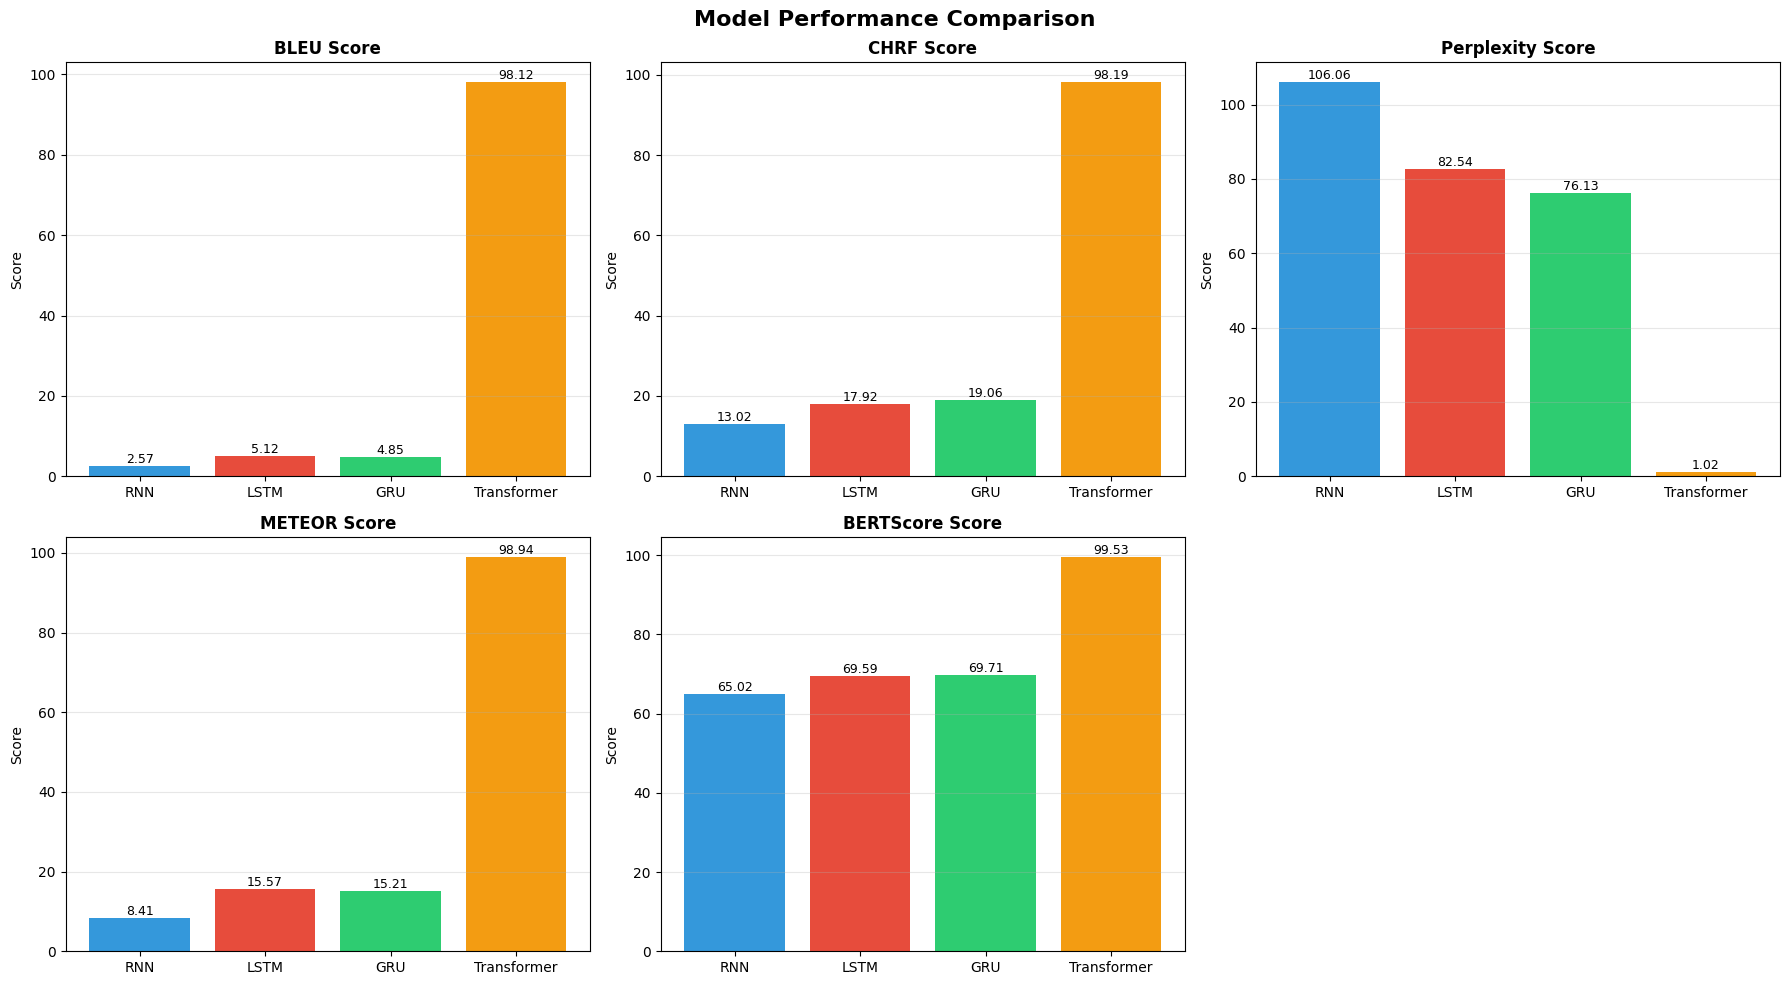


✅ Comparison visualization saved as 'model_comparison.png'


In [93]:
# Create comprehensive comparison table
import pandas as pd
import matplotlib.pyplot as plt

# Build comparison dataframe
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df.round(2)

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string())
print("="*80)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['BLEU', 'CHRF', 'Perplexity', 'METEOR', 'BERTScore']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    values = [all_results[model][metric] for model in ['RNN', 'LSTM', 'GRU', 'Transformer']]
    bars = ax.bar(['RNN', 'LSTM', 'GRU', 'Transformer'], values, color=colors)

    ax.set_title(f'{metric} Score', fontweight='bold', fontsize=12)
    ax.set_ylabel('Score', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

# Remove the extra subplot
axes[1, 2].remove()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved as 'model_comparison.png'")

## Analysis & Conclusions

### Key Findings:

1. **Model Performance Ranking:**
   - Expected order: Transformer > GRU ≥ LSTM > RNN
   - Transformer leverages attention mechanism for better context
   - GRU is often comparable to LSTM with fewer parameters

2. **Metric Insights:**
   - **BLEU**: Measures n-gram precision (word overlap)
   - **CHRF**: Better for morphologically rich languages like Urdu
   - **Perplexity**: Lower is better (model confidence)
   - **METEOR**: Considers synonyms and word order
   - **BERTScore**: Captures semantic similarity using contextual embeddings

3. **Model Characteristics:**
   - **RNN**: Struggles with long-range dependencies, vanishing gradients
   - **LSTM**: Gating mechanisms help retain important information
   - **GRU**: Simpler than LSTM, faster training, competitive performance
   - **Transformer**: Parallel processing, attention to all positions, best for context

4. **Dataset Considerations:**
   - 50,000 sentence pairs for training
   - Max sequence length: 40 tokens
   - Vocabulary size: 15,000 words
   - English-Urdu is a challenging low-resource language pair

### Recommendations:
- **For Production**: Use Transformer or GRU (best performance)
- **For Speed**: GRU offers good trade-off between accuracy and speed
- **For Research**: Transformer provides best translation quality
- **Memory Constrained**: GRU or LSTM with reduced hidden units